# interruption a CRPropa simulation with a source and secondaries

In [35]:
from crpropa import * 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [36]:
def read_crp(file): 
    with open(file, "r") as f: 
        names = f.readline().strip("\n").split("\t")[1:]
    
    return pd.read_csv(file, delimiter="\t", comment ="#", names = names)

## full simulation

In [38]:
n_sim = int(100)

def get_sim(file):
    sim = ModuleList() 
    sim.add(SimplePropagation())

    # add EM interactions 
    photon_fields = [CMB(), IRB_Gilmore12()]
    for field in photon_fields:
        sim.add(EMInverseComptonScattering(field, True)) # allow photons
        sim.add(EMPairProduction(field, True)) # allow electrons 
        sim.add(EMDoublePairProduction(field, True))
        sim.add(EMTripletPairProduction(field, True))

    sim.add(MinimumEnergy(10 * GeV))

    sub_dir = "cascade/"
    out = TextOutput(f"{sub_dir}/{file}")
    out.setEnergyScale(TeV)
    obs = Observer() 
    obs.add(Observer1D())
    obs.add(ObserverInactiveVeto())
    obs.onDetection(out)
    sim.add(obs) 

    source = Source() 
    source.add(SourceParticleType(22))
    source.add(SourcePosition(Vector3d(50 * Mpc, 0, 0)))
    # source.add(SourcePowerLawSpectrum(1 * TeV, 500 * TeV, -1.5))
    source.add(SourceEnergy(100 * TeV))

    sim.setShowProgress(True)
    return source, sim 

source, sim = get_sim("full.txt")
sim.run(source, n_sim)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Wed Sep  4 16:05:00 2024 : [ Finished ] 100%    Needed: 00:01:49  - Finished at Wed Sep  4 16:06:49 2024


In [39]:
# load data 
df_full = read_crp("cascade/full.txt")

## interrupted simulation

In [55]:
source, sim = get_sim("interrupt_1.txt")

interrupt_out = TextOutput(f"cascade/on_interrupt.txt")
sim.setInterruptAction(interrupt_out)

sim.run(source, n_sim)

crpropa::ModuleList: Number of Threads: 12
Run ModuleList


crpropa::ModuleList: Signal 2 (SIGINT/SIGTERM) received


############################################################################
# Interrupted CRPropa simulation 
# Number of not started candidates from source: 41
############################################################################


KeyboardInterrupt: 

In [56]:
df_1 = read_crp(f"cascade/interrupt_1.txt") # at state of interruption

In [57]:
n_missing = 41 # taken from output -> will be different on each try

source, sim = get_sim("interrupt_2.txt")
sim.run(source, n_missing) # use modulelist and source as previously defined

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Wed Sep  4 16:13:45 2024 : [ Finished ] 100%    Needed: 00:00:41  - Finished at Wed Sep  4 16:14:26 2024


In [58]:
df_2 = read_crp(f"cascade/interrupt_2.txt")

In [59]:
# close outputfile before reading 
interrupt_out.close()


pc = ParticleCollector()
pc.load("cascade/on_interrupt.txt")

print("number of loaded particles:", pc.size())

# run simulation with missing particles
source, sim = get_sim("interrupt_3.txt")
sim.run(pc.getContainer())

number of loaded particles: 16527
crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Wed Sep  4 16:14:27 2024 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Wed Sep  4 16:14:27 2024


In [60]:
df_3 = read_crp("cascade/interrupt_3.txt")

# show spectrum at earth

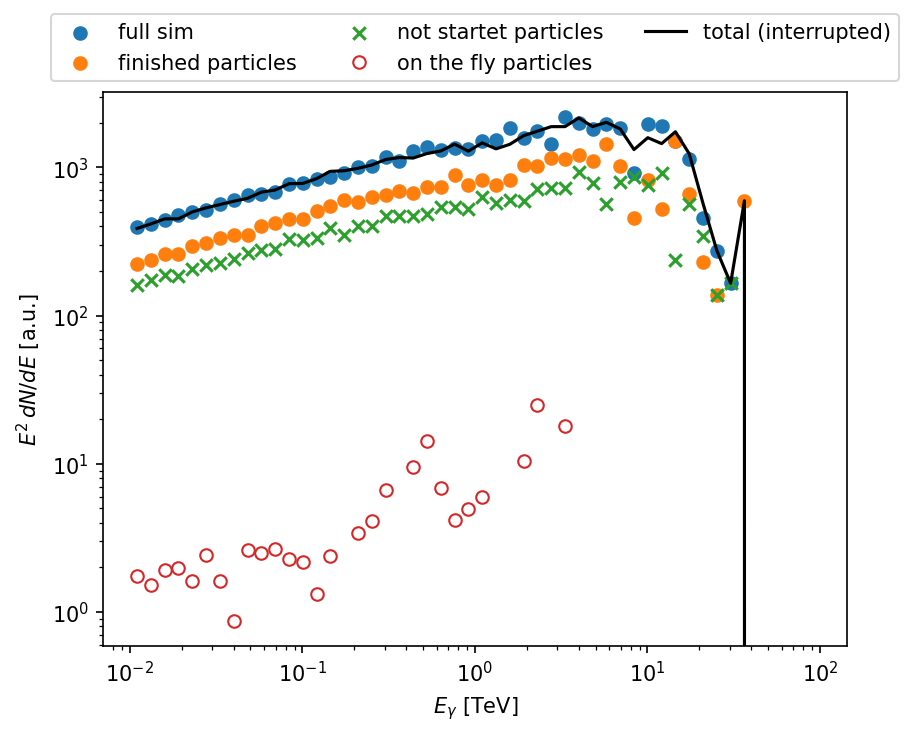

In [61]:
e_bins = np.logspace(-2, 2, 51)
dE = np.diff(e_bins)
e_mid = 0.5 * (e_bins[1:] + e_bins[:-1])

get_dnde = lambda df: np.histogram(df[df.ID == 22].E, bins = e_bins)[0]/dE 

dNdE_full = get_dnde(df_full)
dNdE_1 = get_dnde(df_1)
dNdE_2 = get_dnde(df_2)
dNdE_3 = get_dnde(df_3) 

plt.figure(dpi = 150)
plt.scatter(e_mid, e_mid**2 * dNdE_full, label = "full sim") 
plt.scatter(e_mid, e_mid**2 * dNdE_1, label = "finished particles", marker ="o",)
plt.scatter(e_mid, e_mid**2 * dNdE_2, label = "not startet particles", marker ="x")
plt.plot(e_mid, e_mid**2 * dNdE_3, label = "on the fly particles", fillstyle="none", ls = "",marker ="o", color = "tab:red")

plt.plot(e_mid, e_mid**2 * (dNdE_1 + dNdE_2 + dNdE_3), label ="total (interrupted)", color ="k")


plt.loglog() 
plt.xlabel(r"$E_\gamma$ [TeV]")
plt.ylabel(r"$E^2 \, dN/dE$ [a.u.]")
plt.legend(loc = "lower center", ncol = 3, bbox_to_anchor=(0.5, 1.))
plt.show()